In [2]:
import torch
from torch import nn
from mamba_ssm import Mamba

In [6]:
import os
from glob import glob
import pandas as pd 
import cv2
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16_bn
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
# function to create dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')
    print(masks_paths)

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [8]:
data_path = "../datasets/lgg-mri-segmentation/kaggle_3m"
df = create_df(data_path)
train_df, val_df, test_df = split_df(df)

['../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_25_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_46_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_57_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_48_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_11_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_33_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_38_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_22_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_18_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19

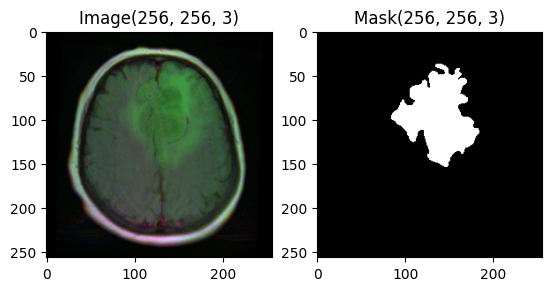

In [11]:
image = cv2.imread(train_df.iloc[5, 0]) / 255.0
mask = cv2.imread(train_df.iloc[5, 1]) / 255.0
mask = np.where(mask>=0.5, 1., 0.)

plt.subplot(1,2,1)
plt.imshow(image)
plt.title('Image'+str(image.shape))
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title('Mask'+str(mask.shape))
plt.show()

In [12]:
class Brain_mri_dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe  ,  transform = None ,  mask_transform= None):
        self.df = dataframe #pd.read_csv(annotations_file)
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self , idx):
        image = cv2.imread(self.df.iloc[idx, 0]) / 255.0
        mask = cv2.imread(self.df.iloc[idx, 1])  / 255.0
        mask = np.where(mask>=0.5, 1., 0.)
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [13]:
transform_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

train_data = Brain_mri_dataset(train_df, transform = transform_ ,  mask_transform= transform_)
val_data = Brain_mri_dataset(val_df, transform = transform_ ,  mask_transform= transform_)
test_data = Brain_mri_dataset(test_df, transform = transform_ ,  mask_transform= transform_)

batch_size = 1

train_dataloader = DataLoader(train_data, batch_size = batch_size , shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size , shuffle = True)



In [14]:
print('Training batches\t', len(train_dataloader))
print('Validation batches\t', len(val_dataloader))
print('Test batches\t\t', len(test_dataloader))

Training batches	 3143
Validation batches	 393
Test batches		 393


In [5]:
import numpy as np
import torch
from torch import nn
from typing import Union, Type, List, Tuple

from dynamic_network_architectures.building_blocks.helper import get_matching_convtransp
from dynamic_network_architectures.building_blocks.residual_encoders import ResidualEncoder
from dynamic_network_architectures.building_blocks.plain_conv_encoder import PlainConvEncoder
from dynamic_network_architectures.building_blocks.residual import StackedResidualBlocks
from dynamic_network_architectures.building_blocks.residual_encoders import ResidualEncoder
from dynamic_network_architectures.building_blocks.residual import BasicBlockD, BottleneckD
from torch.nn.modules.conv import _ConvNd
from torch.nn.modules.dropout import _DropoutNd
from dynamic_network_architectures.building_blocks.helper import convert_conv_op_to_dim

from nnunetv2.utilities.plans_handling.plans_handler import ConfigurationManager, PlansManager
from dynamic_network_architectures.building_blocks.helper import get_matching_instancenorm, convert_dim_to_conv_op
from nnunetv2.utilities.network_initialization import InitWeights_He
from mamba_ssm import Mamba

class UNetResDecoder(nn.Module):
    def __init__(self,
                 encoder: Union[PlainConvEncoder, ResidualEncoder],
                 num_classes: int,
                 n_conv_per_stage: Union[int, Tuple[int, ...], List[int]],
                 deep_supervision, nonlin_first: bool = False):
        """
        This class needs the skips of the encoder as input in its forward.

        the encoder goes all the way to the bottleneck, so that's where the decoder picks up. stages in the decoder
        are sorted by order of computation, so the first stage has the lowest resolution and takes the bottleneck
        features and the lowest skip as inputs
        the decoder has two (three) parts in each stage:
        1) conv transpose to upsample the feature maps of the stage below it (or the bottleneck in case of the first stage)
        2) n_conv_per_stage conv blocks to let the two inputs get to know each other and merge
        3) (optional if deep_supervision=True) a segmentation output Todo: enable upsample logits?
        :param encoder:
        :param num_classes:
        :param n_conv_per_stage:
        :param deep_supervision:
        """
        super().__init__()
        self.deep_supervision = deep_supervision
        self.encoder = encoder
        self.num_classes = num_classes
        n_stages_encoder = len(encoder.output_channels)
        if isinstance(n_conv_per_stage, int):
            n_conv_per_stage = [n_conv_per_stage] * (n_stages_encoder - 1)
        assert len(n_conv_per_stage) == n_stages_encoder - 1, "n_conv_per_stage must have as many entries as we have " \
                                                          "resolution stages - 1 (n_stages in encoder - 1), " \
                                                          "here: %d" % n_stages_encoder

        transpconv_op = get_matching_convtransp(conv_op=encoder.conv_op)

        # we start with the bottleneck and work out way up
        stages = []
        transpconvs = []
        seg_layers = []
        for s in range(1, n_stages_encoder):
            input_features_below = encoder.output_channels[-s]
            input_features_skip = encoder.output_channels[-(s + 1)]
            stride_for_transpconv = encoder.strides[-s]
            transpconvs.append(transpconv_op(
                input_features_below, input_features_skip, stride_for_transpconv, stride_for_transpconv,
                bias=encoder.conv_bias
            ))
            # input features to conv is 2x input_features_skip (concat input_features_skip with transpconv output)
            stages.append(StackedResidualBlocks(
                n_blocks = n_conv_per_stage[s-1],
                conv_op = encoder.conv_op,
                input_channels = 2 * input_features_skip,
                output_channels = input_features_skip,
                kernel_size = encoder.kernel_sizes[-(s + 1)],
                initial_stride = 1,
                conv_bias = encoder.conv_bias,
                norm_op = encoder.norm_op,
                norm_op_kwargs = encoder.norm_op_kwargs,
                dropout_op = encoder.dropout_op,
                dropout_op_kwargs = encoder.dropout_op_kwargs,
                nonlin = encoder.nonlin,
                nonlin_kwargs = encoder.nonlin_kwargs,
            ))

            # we always build the deep supervision outputs so that we can always load parameters. If we don't do this
            # then a model trained with deep_supervision=True could not easily be loaded at inference time where
            # deep supervision is not needed. It's just a convenience thing
            seg_layers.append(encoder.conv_op(input_features_skip, num_classes, 1, 1, 0, bias=True))

        self.stages = nn.ModuleList(stages)
        self.transpconvs = nn.ModuleList(transpconvs)
        self.seg_layers = nn.ModuleList(seg_layers)

    def forward(self, skips):
        """
        we expect to get the skips in the order they were computed, so the bottleneck should be the last entry
        :param skips:
        :return:
        """
        lres_input = skips[-1]
        seg_outputs = []
        for s in range(len(self.stages)):
            x = self.transpconvs[s](lres_input)
            x = torch.cat((x, skips[-(s+2)]), 1)
            x = self.stages[s](x)
            if self.deep_supervision:
                seg_outputs.append(self.seg_layers[s](x))
            elif s == (len(self.stages) - 1):
                seg_outputs.append(self.seg_layers[-1](x))
            lres_input = x

        # invert seg outputs so that the largest segmentation prediction is returned first
        seg_outputs = seg_outputs[::-1]

        if not self.deep_supervision:
            r = seg_outputs[0]
        else:
            r = seg_outputs
        return r

    def compute_conv_feature_map_size(self, input_size):
        """
        IMPORTANT: input_size is the input_size of the encoder!
        :param input_size:
        :return:
        """
        # first we need to compute the skip sizes. Skip bottleneck because all output feature maps of our ops will at
        # least have the size of the skip above that (therefore -1)
        skip_sizes = []
        for s in range(len(self.encoder.strides) - 1):
            skip_sizes.append([i // j for i, j in zip(input_size, self.encoder.strides[s])])
            input_size = skip_sizes[-1]
        # print(skip_sizes)

        assert len(skip_sizes) == len(self.stages)

        # our ops are the other way around, so let's match things up
        output = np.int64(0)
        for s in range(len(self.stages)):
            # print(skip_sizes[-(s+1)], self.encoder.output_channels[-(s+2)])
            # conv blocks
            output += self.stages[s].compute_conv_feature_map_size(skip_sizes[-(s+1)])
            # trans conv
            output += np.prod([self.encoder.output_channels[-(s+2)], *skip_sizes[-(s+1)]], dtype=np.int64)
            # segmentation
            if self.deep_supervision or (s == (len(self.stages) - 1)):
                output += np.prod([self.num_classes, *skip_sizes[-(s+1)]], dtype=np.int64)
        return output
    
class UMambaBot(nn.Module):
    def __init__(self,
                 input_channels: int,
                 n_stages: int,
                 features_per_stage: Union[int, List[int], Tuple[int, ...]],
                 conv_op: Type[_ConvNd],
                 kernel_sizes: Union[int, List[int], Tuple[int, ...]],
                 strides: Union[int, List[int], Tuple[int, ...]],
                 n_conv_per_stage: Union[int, List[int], Tuple[int, ...]],
                 num_classes: int,
                 n_conv_per_stage_decoder: Union[int, Tuple[int, ...], List[int]],
                 conv_bias: bool = False,
                 norm_op: Union[None, Type[nn.Module]] = None,
                 norm_op_kwargs: dict = None,
                 dropout_op: Union[None, Type[_DropoutNd]] = None,
                 dropout_op_kwargs: dict = None,
                 nonlin: Union[None, Type[torch.nn.Module]] = None,
                 nonlin_kwargs: dict = None,
                 deep_supervision: bool = False,
                 block: Union[Type[BasicBlockD], Type[BottleneckD]] = BasicBlockD,
                 bottleneck_channels: Union[int, List[int], Tuple[int, ...]] = None,
                 stem_channels: int = None
                 ):
        super().__init__()
        n_blocks_per_stage = n_conv_per_stage
        if isinstance(n_blocks_per_stage, int):
            n_blocks_per_stage = [n_blocks_per_stage] * n_stages
        if isinstance(n_conv_per_stage_decoder, int):
            n_conv_per_stage_decoder = [n_conv_per_stage_decoder] * (n_stages - 1)
        assert len(n_blocks_per_stage) == n_stages, "n_blocks_per_stage must have as many entries as we have " \
                                                  f"resolution stages. here: {n_stages}. " \
                                                  f"n_blocks_per_stage: {n_blocks_per_stage}"
        assert len(n_conv_per_stage_decoder) == (n_stages - 1), "n_conv_per_stage_decoder must have one less entries " \
                                                                f"as we have resolution stages. here: {n_stages} " \
                                                                f"stages, so it should have {n_stages - 1} entries. " \
                                                                f"n_conv_per_stage_decoder: {n_conv_per_stage_decoder}"
        self.encoder = ResidualEncoder(input_channels, n_stages, features_per_stage, conv_op, kernel_sizes, strides,
                                       n_blocks_per_stage, conv_bias, norm_op, norm_op_kwargs, dropout_op,
                                       dropout_op_kwargs, nonlin, nonlin_kwargs, block, bottleneck_channels,
                                       return_skips=True, disable_default_stem=False, stem_channels=stem_channels)
        # layer norm
        self.ln = nn.LayerNorm(features_per_stage[-1])
        self.mamba = Mamba(
                        d_model=features_per_stage[-1],
                        d_state=16,  
                        d_conv=4,    
                        expand=2,   
                    )
        self.decoder = UNetResDecoder(self.encoder, num_classes, n_conv_per_stage_decoder, deep_supervision)

    def forward(self, x):
        skips = self.encoder(x)
        middle_feature = skips[-1]
        B, C = middle_feature.shape[:2]
        n_tokens = middle_feature.shape[2:].numel()
        img_dims = middle_feature.shape[2:]
        middle_feature_flat = middle_feature.view(B, C, n_tokens).transpose(-1, -2)
        middle_feature_flat = self.ln(middle_feature_flat) 
        out = self.mamba(middle_feature_flat)
        out = out.transpose(-1, -2).view(B, C, *img_dims)
        skips[-1] = out
        
        return self.decoder(skips)

    def compute_conv_feature_map_size(self, input_size):
        assert len(input_size) == convert_conv_op_to_dim(self.encoder.conv_op), "just give the image size without color/feature channels or " \
                                                                                "batch channel. Do not give input_size=(b, c, x, y(, z)). " \
                                                                                "Give input_size=(x, y(, z))!"
        return self.encoder.compute_conv_feature_map_size(input_size) + self.decoder.compute_conv_feature_map_size(input_size)


def get_umamba_bot_from_plans(plans_manager: PlansManager,
                           dataset_json: dict,
                           configuration_manager: ConfigurationManager,
                           num_input_channels: int,
                           deep_supervision: bool = True):
    """
    we may have to change this in the future to accommodate other plans -> network mappings

    num_input_channels can differ depending on whether we do cascade. Its best to make this info available in the
    trainer rather than inferring it again from the plans here.
    """
    num_stages = len(configuration_manager.conv_kernel_sizes)

    dim = len(configuration_manager.conv_kernel_sizes[0])
    conv_op = convert_dim_to_conv_op(dim)

    label_manager = plans_manager.get_label_manager(dataset_json)

    segmentation_network_class_name = 'UMambaBot'
    network_class = UMambaBot
    kwargs = {
        'UMambaBot': {
            'conv_bias': True,
            'norm_op': get_matching_instancenorm(conv_op),
            'norm_op_kwargs': {'eps': 1e-5, 'affine': True},
            'dropout_op': None, 'dropout_op_kwargs': None,
            'nonlin': nn.LeakyReLU, 'nonlin_kwargs': {'inplace': True},
        }
    }

    conv_or_blocks_per_stage = {
        'n_conv_per_stage': configuration_manager.n_conv_per_stage_encoder,
        'n_conv_per_stage_decoder': configuration_manager.n_conv_per_stage_decoder
    }

    model = network_class(
        input_channels=num_input_channels,
        n_stages=num_stages,
        features_per_stage=[min(configuration_manager.UNet_base_num_features * 2 ** i,
                                configuration_manager.unet_max_num_features) for i in range(num_stages)],
        conv_op=conv_op,
        kernel_sizes=configuration_manager.conv_kernel_sizes,
        strides=configuration_manager.pool_op_kernel_sizes,
        num_classes=label_manager.num_segmentation_heads,
        deep_supervision=deep_supervision,
        **conv_or_blocks_per_stage,
        **kwargs[segmentation_network_class_name]
    )
    model.apply(InitWeights_He(1e-2))

    return model


In [ ]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 100
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2).sum()

        return 1 - ((2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth))


In [17]:
def IOU(y_true, y_pred, smooth=100):
    intersection = (y_true * y_pred).sum()
    sum = (y_true + y_pred).sum()
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [16]:
model = UMambaBot().to(device)

TypeError: UMambaBot.__init__() missing 9 required positional arguments: 'input_channels', 'n_stages', 'features_per_stage', 'conv_op', 'kernel_sizes', 'strides', 'n_conv_per_stage', 'num_classes', and 'n_conv_per_stage_decoder'